# Mobile Net Transfer Learning

Loading the pre-trained comvolutional models, removing the last layer and train with small data set.

In [1]:
#from keras.applications import ResNet50
#from keras.applications import InceptionV3
#from keras.applications import Xception
#from keras.applications import VGG16
#from keras.applications import VGG19


In [2]:
#from keras.applications.mobilenet import MobileNet


In [3]:
#MobileNet = MobileNet()
#ResNet = ResNet50()
#XceptionNet = Xception()
#VGG16 = VGG16()
#VGG19 = VGG19()

In [4]:
#InceptionV3Net = InceptionV3(input_shape=(299,299,3))


In [5]:
#XceptionNet = Xception()

In [6]:
#ResNet.summary()

In [7]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Reshape, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from Transfer_learning_utils import convert_to_one_hot, loading_dataset, evaluate_model

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
from keras.applications.mobilenet import MobileNet
MobileNet = MobileNet()
MobileNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

## load training and testing data

In [9]:
selected_classes = ['garfield','barrel','camera','cannon','crab','crayfish','crocdile','llama','lobster','lotus','sunflower']
folderpath = './../Dataset/Caltech101_Dataset/101_ObjectCategories/'

In [10]:
X_train, Y_train, X_test, Y_test = loading_dataset(folderpath = folderpath, classes = selected_classes)

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train, len(selected_classes)).T
Y_test = convert_to_one_hot(Y_test, len(selected_classes)).T

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 470
number of test examples = 117
X_train shape: (470, 224, 224, 3)
Y_train shape: (470, 11)
X_test shape: (117, 224, 224, 3)
Y_test shape: (117, 11)


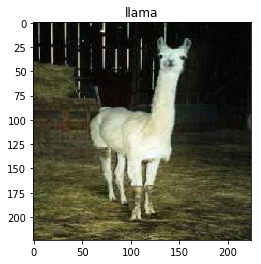

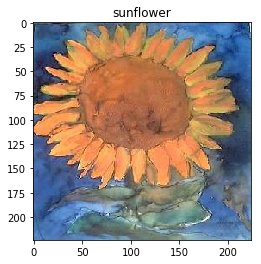

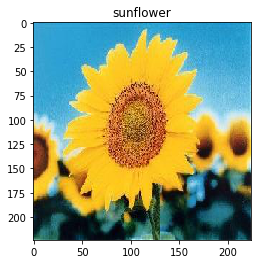

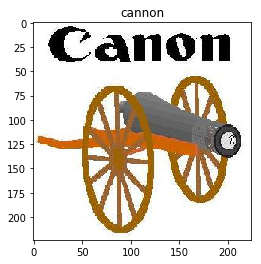

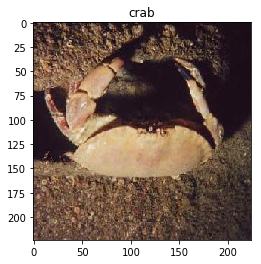

In [12]:
for i in range(5):
    plt.figure()
    plt.imshow(X_train[i]/255.)
    plt.title(selected_classes[np.argmax(Y_train[i])])

## Add new fianl dense layer, set MobileNet layers non-trainable

In [13]:
for layer in MobileNet.layers:
    layer.trainable = False

### Note for Mobile Net
The last 3 layers of MobileNet are conv2d, softmax activation and reshape. We need to 
1. Remove the last reshape
2. Remove the 2nd last layer (softmax activation layer).
3. Attach a new reshape layer to the conv2d layer to change the shape from (None, 1,1, 1000) to (None, 1000)
4. Attach a dense layer for classfication with softmax activation 

In [14]:
n_last_kept_dim = int(MobileNet.layers[-3].output.shape[3])
X = Reshape((n_last_kept_dim,),name = 'reshape_for_feature')(MobileNet.layers[-3].output)

In [15]:
featureModel = Model(input = MobileNet.input, output = X)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  """Entry point for launching an IPython kernel.


In [16]:
nTrain = X_train.shape[0]
nTest = X_test.shape[0]

nFeature = int(featureModel.output.shape[1])

X_train_feature = np.zeros((nTrain, nFeature))
X_test_feature  = np.zeros((nTest, nFeature))

In [17]:
batch_size = 10
for i in range(0,nTrain,batch_size):
    iEnd = min([nTrain, i+batch_size])
    print('computing features for training data %d - %d' % (i, iEnd-1))
    X_train_feature[i:iEnd] = featureModel.predict(X_train[i:iEnd])    

computing features for training data 0 - 9
computing features for training data 10 - 19
computing features for training data 20 - 29
computing features for training data 30 - 39
computing features for training data 40 - 49
computing features for training data 50 - 59
computing features for training data 60 - 69
computing features for training data 70 - 79
computing features for training data 80 - 89
computing features for training data 90 - 99
computing features for training data 100 - 109
computing features for training data 110 - 119
computing features for training data 120 - 129
computing features for training data 130 - 139
computing features for training data 140 - 149
computing features for training data 150 - 159
computing features for training data 160 - 169
computing features for training data 170 - 179
computing features for training data 180 - 189
computing features for training data 190 - 199
computing features for training data 200 - 209
computing features for training dat

In [18]:
for i in range(0,nTest,batch_size):
    iEnd = min([nTest, i+batch_size])
    print('computing features for test data %d - %d' % (i, iEnd-1))
    X_test_feature[i:iEnd] = featureModel.predict(X_test[i:iEnd])   

computing features for test data 0 - 9
computing features for test data 10 - 19
computing features for test data 20 - 29
computing features for test data 30 - 39
computing features for test data 40 - 49
computing features for test data 50 - 59
computing features for test data 60 - 69
computing features for test data 70 - 79
computing features for test data 80 - 89
computing features for test data 90 - 99
computing features for test data 100 - 109
computing features for test data 110 - 116


In [19]:
pca = decomposition.PCA(n_components = 2)

In [20]:
x_std = StandardScaler().fit_transform(X_train_feature)
x_feature_pca = pca.fit_transform(x_std)

In [21]:
Y_train_label = np.argmax(Y_train,axis=1)

Text(0.5,1,'feature space')

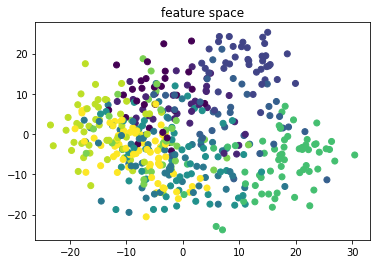

In [22]:
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=Y_train_label)
plt.title('feature space')

### Note:
Before we do anything, the n-1 layers of MobileNet is already able to distinguage different classes. Here we compute the feature vectors of each training and testing data set, and plot the feature vectors (the first two dimensions in the pca space) colored by their labels. Note that there are some level of separation already between clusters. Compared to VGG, the clusters are less separated.

In [23]:
nFeature

1000

In [24]:
final_layer_input = Input(shape=(nFeature,))
X = Dense(len(selected_classes), activation='softmax', kernel_initializer = glorot_uniform(seed=0))(final_layer_input)
#X = Dense(64, activation='relu', kernel_initializer = glorot_uniform(seed=0))(final_layer_input)
#X = Dropout(0.6)(X)
#X = Dense(len(selected_classes), activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
myMobileNet_patch = Model(inputs = final_layer_input, outputs = X)
myMobileNet_patch.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [25]:
myMobileNet_patch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                11011     
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [26]:
evaluate_model(myMobileNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)

Performance on Training data set (470)
470/470 [==============================] - 0s 464us/step
Loss = 5.456675239319497
Train Accuracy = 0.1382978726574715
Performance on Testing data set (117)
117/117 [==============================] - 0s 68us/step
Loss = 5.452560604128063
Test Accuracy = 0.09401709417629446


(5.456675239319497, 0.1382978726574715, 5.452560604128063, 0.09401709417629446)

In [27]:
loss_train = []
loss_test = []
acc_train = []
acc_test = []

In [28]:
for i in range(100):
    print('Training on %d-th round' % i)
    myMobileNet_patch.fit(X_train_feature, Y_train, epochs = 2, batch_size = 32)
    ltr, atr, lte, ate = evaluate_model(myMobileNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)
    loss_train.append(ltr)
    acc_train.append(atr)
    loss_test.append(lte)
    acc_test.append(ate)

Training on 0-th round
Epoch 1/2
470/470 [==============================] - 0s 607us/step - loss: 2.7134 - acc: 0.4106
Epoch 2/2
470/470 [==============================] - 0s 57us/step - loss: 0.7483 - acc: 0.7787
Performance on Training data set (470)
470/470 [==============================] - 0s 35us/step
Loss = 0.4368971268547342
Train Accuracy = 0.8702127651965365
Performance on Testing data set (117)
117/117 [==============================] - 0s 56us/step
Loss = 0.7634771985885425
Test Accuracy = 0.777777779306102
Training on 1-th round
Epoch 1/2
470/470 [==============================] - 0s 63us/step - loss: 0.3736 - acc: 0.8894
Epoch 2/2
470/470 [==============================] - 0s 69us/step - loss: 0.2142 - acc: 0.9298
Performance on Training data set (470)
470/470 [==============================] - 0s 35us/step
Loss = 0.13212204268004032
Train Accuracy = 0.9702127659574468
Performance on Testing data set (117)
117/117 [==============================] - 0s 54us/step
Loss = 0.5

470/470 [==============================] - 0s 66us/step - loss: 0.0041 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 62us/step - loss: 0.0039 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 39us/step
Loss = 0.0037775029874149153
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 71us/step
Loss = 0.5483710057715065
Test Accuracy = 0.8717948723043132
Training on 17-th round
Epoch 1/2
470/470 [==============================] - 0s 57us/step - loss: 0.0038 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 61us/step - loss: 0.0036 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 36us/step
Loss = 0.0034832549677725803
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 70us/step
Loss = 0.549113225733113
Test Accuracy = 0.8632478637573047
Trainin

470/470 [==============================] - 0s 58us/step - loss: 0.0015 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 57us/step - loss: 0.0014 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 41us/step
Loss = 0.0014153461051272585
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 41us/step
Loss = 0.563030975496667
Test Accuracy = 0.8717948723043132
Training on 33-th round
Epoch 1/2
470/470 [==============================] - 0s 60us/step - loss: 0.0014 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 59us/step - loss: 0.0014 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 37us/step
Loss = 0.0013520769978021372
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 48us/step
Loss = 0.5647935887687227
Test Accuracy = 0.8717948723043132
Trainin

470/470 [==============================] - 0s 64us/step - loss: 7.7752e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 69us/step - loss: 7.6556e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 38us/step
Loss = 0.0007516425729610343
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 65us/step
Loss = 0.5758464499416515
Test Accuracy = 0.8717948723043132
Training on 49-th round
Epoch 1/2
470/470 [==============================] - 0s 57us/step - loss: 7.5164e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 59us/step - loss: 7.4033e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 40us/step
Loss = 0.0007266730840436797
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 57us/step
Loss = 0.5767700600827861
Test Accuracy = 0.8717948

117/117 [==============================] - 0s 54us/step
Loss = 0.5865144337344373
Test Accuracy = 0.8717948723043132
Training on 64-th round
Epoch 1/2
470/470 [==============================] - 0s 64us/step - loss: 4.7503e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 69us/step - loss: 4.6792e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 38us/step
Loss = 0.0004616091525717143
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 83us/step
Loss = 0.5866848495271471
Test Accuracy = 0.8717948723043132
Training on 65-th round
Epoch 1/2
470/470 [==============================] - 0s 60us/step - loss: 4.6159e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 57us/step - loss: 4.5520e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 41us/step
Loss = 0.00044919425569613406
Train Accuracy

470/470 [==============================] - 0s 29us/step
Loss = 0.00031424395212447867
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 50us/step
Loss = 0.5969693232805301
Test Accuracy = 0.8717948723043132
Training on 80-th round
Epoch 1/2
470/470 [==============================] - 0s 53us/step - loss: 3.1455e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 57us/step - loss: 3.1045e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 34us/step
Loss = 0.0003069735890095855
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 73us/step
Loss = 0.5981528254655691
Test Accuracy = 0.8717948723043132
Training on 81-th round
Epoch 1/2
470/470 [==============================] - 0s 60us/step - loss: 3.0688e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 59us/step - loss: 3.0318e-04 - acc: 1

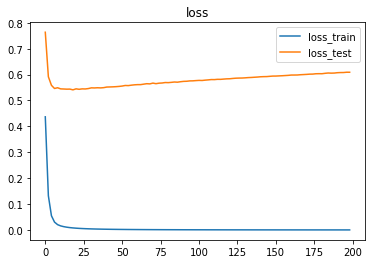

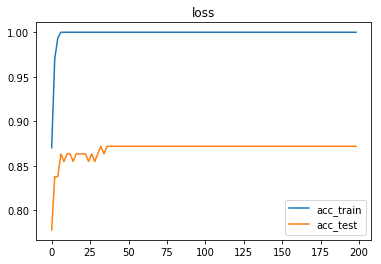

In [30]:
plt.figure()
plt.plot(range(0,200,2), loss_train, label = 'loss_train')
plt.plot(range(0,200,2), loss_test, label = 'loss_test')
plt.title('loss')
plt.legend()

plt.figure()
plt.plot(range(0,200,2), acc_train, label = 'acc_train')
plt.plot(range(0,200,2), acc_test, label = 'acc_test')
plt.title('loss')
plt.legend()

In [31]:
myMobileNet_patch.fit(X_train_feature, Y_train, epochs = 250, batch_size = 32)

Epoch 1/250
470/470 [==============================] - 0s 78us/step - loss: 2.0168e-04 - acc: 1.0000
Epoch 2/250
470/470 [==============================] - 0s 76us/step - loss: 1.9952e-04 - acc: 1.0000
Epoch 3/250
470/470 [==============================] - 0s 61us/step - loss: 1.9735e-04 - acc: 1.0000
Epoch 4/250
470/470 [==============================] - 0s 55us/step - loss: 1.9535e-04 - acc: 1.0000
Epoch 5/250
470/470 [==============================] - 0s 65us/step - loss: 1.9327e-04 - acc: 1.0000
Epoch 6/250
470/470 [==============================] - 0s 74us/step - loss: 1.9153e-04 - acc: 1.0000
Epoch 7/250
470/470 [==============================] - 0s 73us/step - loss: 1.8942e-04 - acc: 1.0000
Epoch 8/250
470/470 [==============================] - 0s 61us/step - loss: 1.8747e-04 - acc: 1.0000
Epoch 9/250
470/470 [==============================] - 0s 65us/step - loss: 1.8561e-04 - acc: 1.0000
Epoch 10/250
470/470 [==============================] - 0s 73us/step - loss: 1.8393e-04 - a

470/470 [==============================] - 0s 65us/step - loss: 4.7979e-05 - acc: 1.0000
Epoch 161/250
470/470 [==============================] - 0s 67us/step - loss: 4.7600e-05 - acc: 1.0000
Epoch 162/250
470/470 [==============================] - 0s 78us/step - loss: 4.7255e-05 - acc: 1.0000
Epoch 163/250
470/470 [==============================] - 0s 63us/step - loss: 4.6843e-05 - acc: 1.0000
Epoch 164/250
470/470 [==============================] - 0s 65us/step - loss: 4.6484e-05 - acc: 1.0000
Epoch 165/250
470/470 [==============================] - 0s 66us/step - loss: 4.6047e-05 - acc: 1.0000
Epoch 166/250
470/470 [==============================] - 0s 73us/step - loss: 4.5725e-05 - acc: 1.0000
Epoch 167/250
470/470 [==============================] - 0s 71us/step - loss: 4.5333e-05 - acc: 1.0000
Epoch 168/250
470/470 [==============================] - 0s 75us/step - loss: 4.4965e-05 - acc: 1.0000
Epoch 169/250
470/470 [==============================] - 0s 68us/step - loss: 4.4624e-0

In [32]:
#the following code will take long time because we are computing the feature vector for each training data repeatedly

#myVGGNet.fit(X_train, Y_train, epochs = 2, batch_size = 32)

In [33]:
#evaluate_model(myVGGNet, X_train, Y_train, X_test, Y_test, maxItem = 20)

In [34]:
#prediction_result = myVGGNet.predict(X_test[0:10])
#predicted_labels = np.argmax(prediction_result,axis=1)

In [35]:
evaluate_model(myMobileNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)

Performance on Training data set (470)
470/470 [==============================] - 0s 38us/step
Loss = 2.3277939683968262e-05
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 57us/step
Loss = 0.6742702503489633
Test Accuracy = 0.8803418808513217


(2.3277939683968262e-05, 1.0, 0.6742702503489633, 0.8803418808513217)

In [36]:
prediction_result = myMobileNet_patch.predict(X_test_feature)
predicted_labels = np.argmax(prediction_result,axis=1)
prediction_conf = np.max(prediction_result, axis = 1)

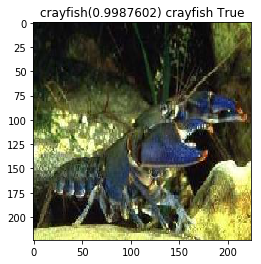

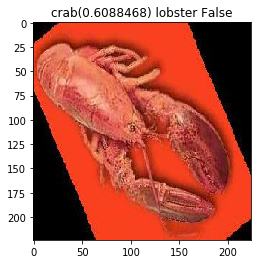

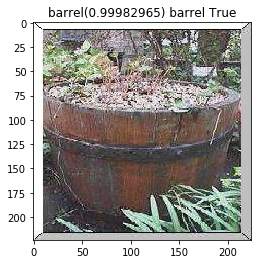

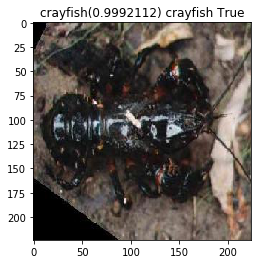

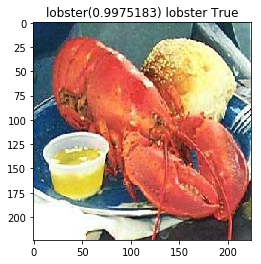

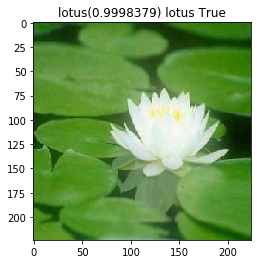

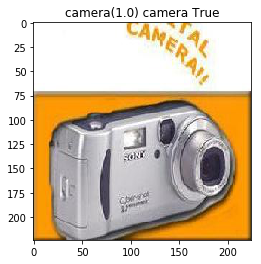

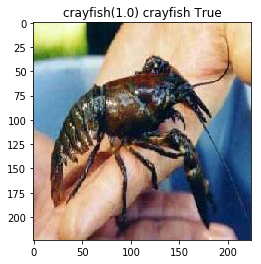

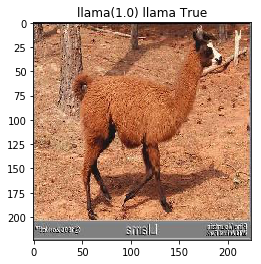

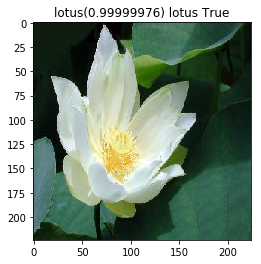

In [37]:
for i in range(10):
    actu = np.argmax(Y_test[i])
    plt.figure()
    plt.imshow(X_test[i]/255.)
    plt.title(selected_classes[predicted_labels[i]] + '(' + str(prediction_conf[i])+') ' + selected_classes[actu] + ' ' + str(predicted_labels[i]==actu))    

## Bravo!
Using only ~400 images of 5 classes, the Conv model transfer-learned from MobileNet model reached 100% accuracy in training data set and 95.5% accuracy in test data set. Training the model takes almost instantaneous time because the feature vectors computed from the (n-1) layers of Mobile Net already contained most information. 

## Notes on Mobile Net
Mobile Network is a small size Convolutional neural network model. It contains only 4M trainable parameters. Computing the feature vectors using pre-trained MobileNet takes much short time than VGG16 or VGG19. Also the model is only 3.3% the size of VGG16

In [38]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

NameError: name 'plot_model' is not defined